In [3]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
%precision 4
plt.style.use('ggplot')
np.random.seed(1234)
import pystan
import scipy.stats as stats
import qgrid

In [53]:
#qgrid.nbinstall(overwrite=True)

In [4]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 50)

In [169]:
pga = pd.read_csv(filepath_or_buffer='data/rshot-2016.txt', sep=';', skipinitialspace=True)

In [175]:
[c for c in pga.columns]

['Tour Code',
 'Tour Description',
 'Year',
 'Tourn.#',
 'Player #',
 'Course #',
 'Permanent Tournament #',
 'Player First Name',
 'Player Last Name',
 'Round',
 'Tournament Name',
 'Course Name',
 'Hole',
 'Hole Score',
 'Par Value',
 'Yardage',
 'Shot',
 'Shot Type(S/P/D)',
 '# of Strokes',
 'From Location(Scorer)',
 'From Location(Enhanced)',
 'To Location(Scorer)',
 'To Location(Enhanced)',
 'Distance',
 'Distance to Pin',
 'In the Hole Flag',
 'Around the Green Flag',
 '1st Putt Flag',
 'Distance to Hole after the Shot',
 'Time',
 'Lie',
 'Elevation',
 'Slope',
 'X Coordinate',
 'Y Coordinate',
 'Z Coordinate',
 'Distance from Center',
 'Distance from Edge',
 'Date',
 'Left/Right',
 'Strokes Gained/Baseline',
 'Strokes Gained Category',
 'Recovery Shot']

In [162]:
# pga[['Player #', 'Player First Name', 'Player Last Name']].drop_duplicates()
top100_names = pd.read_csv(filepath_or_buffer='data/top100.txt', sep=',', header=None)
for i, x in enumerate(top100_names.as_matrix()):
    if i > 9: break
    print i+1,' - ', x[0], x[1]

1  -  Jason Day
2  -  Rory McIlroy
3  -  Brooks Koepka
4  -  Sergio Garcia
5  -  Dustin Johnson
6  -  Adam Scott
7  -  Ryan Palmer
8  -  Justin Rose
9  -  Phil Mickelson
10  -  Hudson Swafford


In [8]:
raw_tournaments =  pga[['Date', 'Tournament Name', 'Course Name', 'Course #']].drop_duplicates().as_matrix()
excluded = ["World Golf Championships-Dell Match Play", "AT&T Pebble Beach Pro-Am" ]
tournaments = raw_tournaments[0]
for i in range(1, len(raw_tournaments)):
    if raw_tournaments[i, 1] != raw_tournaments[i-1, 1]:
        tournaments = np.vstack((tournaments,raw_tournaments[i]))
for exclude in excluded:
    tournaments = tournaments[tournaments[:, 1] != exclude ]
course_map = dict(zip (tournaments[:, 3].tolist(), range(1,39)))

179

In [9]:
raw_players = pga[['Player #', 'Player First Name', 'Player Last Name']].drop_duplicates()
players_ids = []
for name in top100_names.as_matrix():
    players_ids.append(raw_players[(raw_players['Player Last Name'] == name[1]) & (raw_players['Player First Name'] == name[0])]['Player #'].drop_duplicates().tolist()[0])



In [168]:
scores = pga[pga['Player #'].isin(players_ids)].groupby(['Player #', 'Course #', 'Round'])['Shot'].size()
scores

Player Last Name  Player First Name  Course #  Round
Baddeley          Aaron              4         1        73
                                               3        69
                                               4        76
                                     5         3        74
                                               4        74
                                     9         1        77
                                               2        71
                                     11        1        70
                                               2        77
                                     12        1        72
                                               2        71
                                               3        74
                                               4        69
                                     19        1        69
                                               2        78
                                     21        1        71
   

In [11]:
player_map = dict(zip(players_ids, range(1,101)))

In [13]:
raw_rounds = pd.DataFrame(scores.reset_index(name = "Score")).as_matrix()

In [14]:
rounds = np.empty((1, 4), dtype='int')
for t in tournaments:
    rounds = np.vstack((rounds, raw_rounds[raw_rounds[:, 1] == t[3]]))
rounds = rounds[1:,:] 
rounds

array([[ 8075,   552,     1,    72],
       [ 8075,   552,     2,    69],
       [ 8075,   552,     3,    71],
       ..., 
       [40026,   688,     2,    70],
       [40026,   688,     3,    69],
       [40026,   688,     4,    68]])

In [15]:
datum = sorted([[player_map[i[0]], course_map[i[1]], i[3]] for i in rounds],key = lambda (el): el[0])
pp, cc, y = zip(*datum)

In [41]:
rounds = np.zeros([100])
for r in pp:
    rounds[r-1] += 1
rounds = rounds.tolist()

In [164]:

code = """
data {
  int N;
  int N_P;
  int N_C;
  int y[N];
  int pp[N];
  int cc[N];
  real rounds[N_P];
}
# Trending Model
parameters {
  real<lower=-3, upper=3> alpha[N_C];
  real<lower=0, upper=7> sigma[N_P];
  real<lower=65, upper=75> tau[N_P];
  real<lower=-2, upper=2> beta[N_P];
} 
model {
  real trend = 0;
  real m = 1;
  real scale = 1.0/70.0;  #  average score
  y[1] ~ normal(alpha[cc[1]] + tau[pp[1]], sigma[pp[1]]);
  for (n in 2:N) {
    if (pp[n] != pp[n-1])
      m = n;
    trend = 1 - beta[pp[n]]*scale/2 + beta[pp[n]]*(n-m)*scale/rounds[pp[n]];
    y[n] ~ normal(alpha[cc[n]] + tau[pp[n]]*trend, sigma[pp[n]]);
    
  } 
}

"""
data = {
    'N': len (y),
    'y': y,
    'pp' : pp,
    'cc' : cc,
    'N_P' : 100,
    'N_C' : 38,
    'rounds' : rounds
}

fit = pystan.stan(model_code=code, data=data, iter=1000, chains=4)
print fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_56ea4f57d5b62ce8cb2dd5b814a0b211 NOW.


Inference for Stan model: anon_model_56ea4f57d5b62ce8cb2dd5b814a0b211.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]   -0.34    0.02   0.29   -0.9  -0.56  -0.34  -0.14   0.22  196.0   1.01
alpha[1]   -1.12    0.02   0.29  -1.68  -1.31  -1.12  -0.92  -0.53  156.0   1.01
alpha[2]   -1.49    0.02   0.35  -2.16  -1.71  -1.48  -1.25  -0.81  257.0   1.01
alpha[3]   -0.26    0.02   0.32  -0.86  -0.46  -0.26  -0.04   0.37  261.0   1.01
alpha[4]    -2.1    0.02   0.34  -2.74  -2.33  -2.11  -1.88  -1.44  228.0   1.01
alpha[5]   -0.95    0.02    0.4  -1.72  -1.23  -0.95  -0.68  -0.18  322.0   1.01
alpha[6]   -2.78    0.01   0.17  -2.99  -2.92  -2.82  -2.69  -2.37  258.0    1.0
alpha[7]    -0.6    0.02   0.35  -1.28  -0.84   -0.6  -0.37   0.07  293.0   1.01
alpha[8]    2.81  3.6e-3   0.16   2.41   2.74   2.86   2.93   2.99 2000.0    1.0
alp

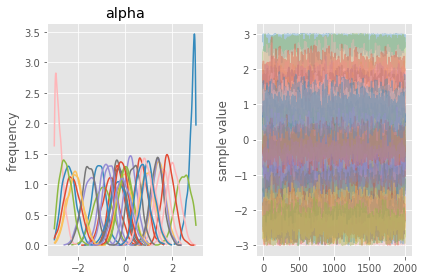

In [165]:
fit.plot(['alpha'])
plt.tight_layout()

In [166]:
means = fit.get_posterior_mean()

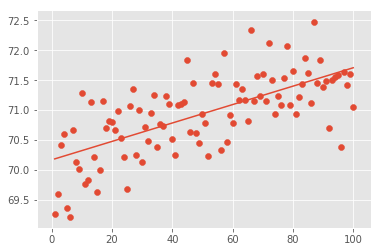

In [167]:
from sklearn import linear_model
clf = linear_model.LinearRegression()
average_adjusted_score = [round(means[i][0],2) for i in range(138,238)]
variates = [[i] for i in range(1, len (average_adusted_score)+1)]

clf.fit(variates, average_adusted_score)
plt.plot(variates, clf.predict(variates))
plt.scatter(variates, average_adusted_score)

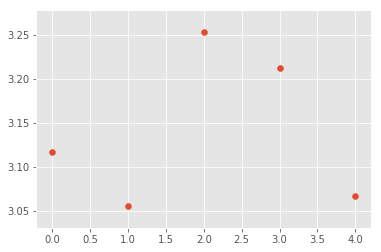

In [153]:
sigma = [round(means[i][0],2) for i in range(38,138)]
num_per_bin = 20
hist = []
bins = [i for i in range(0, len (average_adusted_score)/num_per_bin)]
for i in bins:
    hist.append(np.average(sigma[i*num_per_bin:(i+1)*num_per_bin]))      
plt.scatter(bins, hist)
# plt.scatter(variates, sigma)

[-0.1242] [ 0.1588]


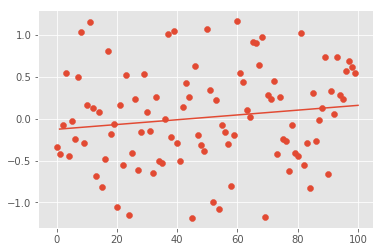

In [101]:
trend = [round(means[i][0],2) for i in range(238,338)]
clf.fit(variates, trend)
plt.plot(variates, clf.predict(variates))
plt.scatter(range(0, len (trend)), trend)
print clf.predict([[1]]), clf.predict([[100]])

In [122]:
# player = top10_ord[top10_ord[:, 1] == "Johnson"][:,  5]
# plt.scatter(np.arange(0, len(player)), player)

In [ ]:
# y = []
# c = []
# for i, p in enumerate(players):
#     y.append(top10_ord[top10_ord[:, 0] == p][:,3].tolist())
#     c.append([course_map[cc] for cc in top10_ord[top10_ord[:, 0] == p][:,1].tolist()])   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68d236bb8fdd18a24e5ada7f59123717 NOW.


Inference for Stan model: anon_model_68d236bb8fdd18a24e5ada7f59123717.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  71.75    0.62   8.43  57.22  65.68  71.55  76.73  89.59  186.0    1.0
beta   -0.03  8.9e-3   0.12  -0.28  -0.11  -0.03   0.06   0.18  186.0    1.0
sigma    3.9    0.03   0.37   3.28   3.64   3.86   4.11   4.74  138.0   1.01
yhat    69.5    0.23   4.06   61.4  66.63  69.71   72.6  77.01  322.0    1.0
lp__  -114.8    0.09   1.39 -118.3 -115.6 -114.5 -113.8 -113.2  231.0    1.0

Samples were drawn using NUTS at Fri Jul 14 23:19:10 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


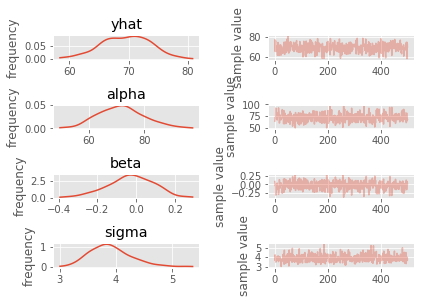

In [130]:
#    Autoregressive model
# parameters {
#   real<lower=-3, upper=3> alpha[N_C];
#   real beta[N_P];
#   real<lower=0> sigma[N_P];
#   real<lower=65, upper=75> tau[N_P];
# } 
# model {
#   y[1] ~ normal(alpha[cc[1]] + tau[pp[1]], sigma[pp[1]]);
#   for (n in 2:N) {
#     if (pp[n-1] == pp[n])
#       y[n] ~ normal(alpha[cc[n]] + tau[pp[n]] + beta[pp[n]] * y[n-1]/72, sigma[pp[n]]);
#     else 
#       y[n] ~ normal(alpha[cc[n]] + tau[pp[n]], sigma[pp[n]]);
#   } 
# }


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_965b4666dd8540917d7c90ccc082fa72 NOW.


Inference for Stan model: anon_model_965b4666dd8540917d7c90ccc082fa72.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     69.87    0.02   0.48   68.9  69.53  69.89  70.19   70.8  464.0    1.0
sigma   3.89    0.02   0.35   3.27   3.65   3.86   4.11   4.65  451.0    1.0
lp__  -113.2    0.06   0.95 -115.5 -113.6 -112.9 -112.5 -112.2  262.0   1.01

Samples were drawn using NUTS at Thu Jul 13 19:01:27 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


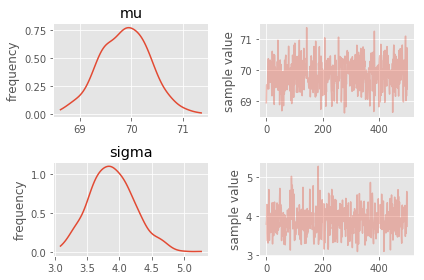

In [90]:
code = """
data {
  int<lower=0> N;
  real y[N]; 
}
parameters {
  real mu;
  real<lower=0> sigma;
} 
model {
  y ~ normal(mu, sigma);
}
"""
data = {
    'N': len (player),
    'y': [x*1.001 for x in player.tolist()]
}

fit = pystan.stan(model_code=code, data=data, iter=1000, chains=1)
print fit
fit.plot(['mu', 'sigma'])
plt.tight_layout()

Inference for Stan model: anon_model_99d207a6cd8130845e3e36373aac0a77.
1 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=500.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    -1.26    0.03   0.49  -2.16  -1.56  -1.27  -0.93  -0.23  345.0    1.0
beta[0]   0.38  6.1e-3   0.13   0.13   0.29   0.38   0.46   0.62  427.0    1.0
sigma     3.21    0.01   0.29    2.7   3.02   3.19    3.4   3.84  410.0    1.0
yhat     67.79    0.14   2.95  61.85  65.51  67.83  69.92  73.59  432.0    1.0
lp__    -105.9    0.09   1.43 -109.2 -106.7 -105.5 -104.9 -104.2  272.0    1.0

Samples were drawn using NUTS at Wed Jul 12 07:49:19 2017.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


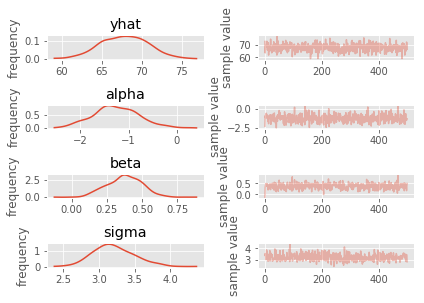

In [51]:
print fit
fit.plot(['yhat', 'alpha','beta', 'sigma'])
plt.tight_layout()